### Stuart-Landau model

In [1]:
import itertools
from functools import partial

import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy
import xarray as xr
from frites.core import copnorm_nd, gcmi_1d_cc, gcmi_nd_cc
from frites.utils import parallel_func
from hoi.core import get_mi
from tqdm import tqdm

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

#### Model definition

In [3]:
def randn(mu: float = 0, sig: float = 0, size: tuple = (1,), seed: int = 0):

    return jax.random.normal(jax.random.key(seed), shape=size)


def _ode(Z: np.complex128, a: float, w: float, Iext: float):
    return Z * (a + 1j * w - np.abs(Z * Z)) + Iext


def simulate(
    f: float,
    a: float,
    beta: float,
    T: np.ndarray = np.arange(-0.5, 1, 1e-4),
    Iext: np.ndarray = None,
    seed: int = 0,
    decim: int = 1,
    mode: str = "amp",
):

    assert mode in ["amp", "phase", "both"]

    gain = 0
    phi = 0
    if mode == "amp":
        gain = 1
    elif mode == "phase":
        gain = 1
        phi = np.pi / 2

    # Model patameters
    w_0 = 2 * np.pi * f

    # Simulation parameters
    dt = np.diff(T)[0]

    if Iext is None:
        Iext = np.zeros_like(T)

    Z = dt + dt * 1j

    eta_1 = randn(seed=seed, size=(len(T),))
    eta_2 = randn(seed=seed + 1000, size=(len(T),))
    eta = np.sqrt(dt) * beta * (eta_1 + 1j * eta_2)

    def _loop(carry, t):
        Z, eta, Iext = carry

        exp_phi = gain * np.exp(1j * (np.angle(Z) + phi))

        Z = Z + dt * _ode(Z, a, w_0, Iext[t] * exp_phi) + eta[t]

        carry = Z, eta, Iext

        return carry, Z

    _, Z = jax.lax.scan(_loop, (Z, eta, Iext), np.arange(len(T)))

    return Z[..., ::decim]

#### Bifurcation diagram

In [4]:
a_vec = np.linspace(-5, 5, 100)

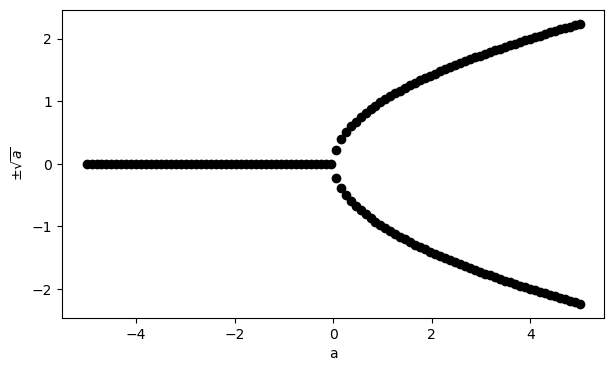

In [5]:
plt.figure(figsize=(7, 4))
for a in a_vec:

    if a <= 0:
        plt.scatter(a, 0, c="k")
    else:
        fp = np.sqrt(a)
        plt.scatter(a, -fp, c="k")
        plt.scatter(a, fp, c="k")
plt.xlabel("a")
plt.ylabel(r"$\pm \sqrt{a}$");

#### Phase diagrams without noise

In [6]:
a_vec = np.array([-5, 0, 5])

In [7]:
Z = [simulate(40, a, 0, seed=0) for a in a_vec]

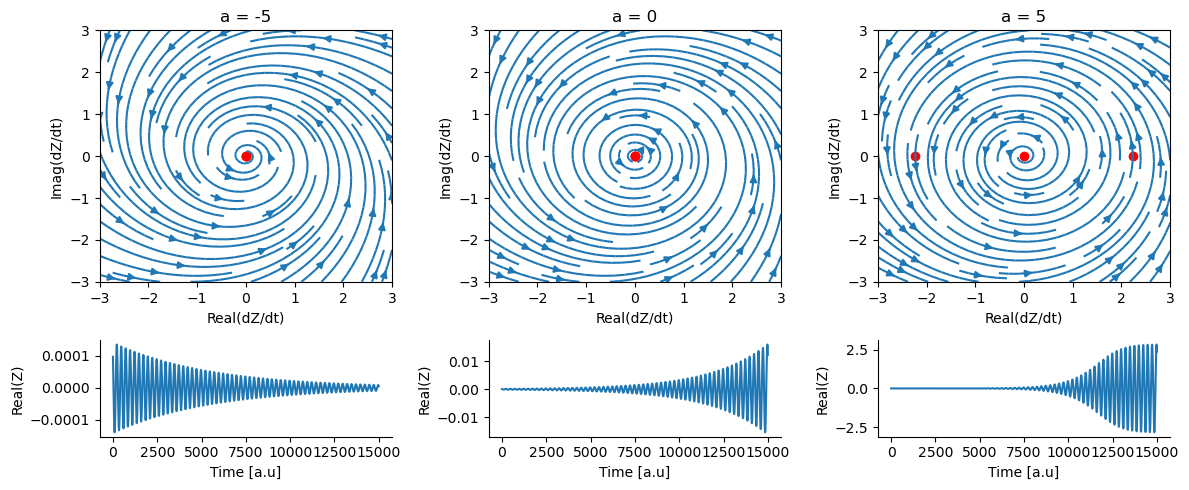

In [8]:
fig, axs = plt.subplot_mosaic([[0, 2, 4], [0, 2, 4], [1, 3, 5]], figsize=(12, 5))

pos = 0
for i, Z_ in enumerate(Z):

    fp = np.sqrt(a_vec[i] + 1j * 0)
    if a_vec[i] < 0:
        fp = 0 + 1j * 0

    fixed_points = np.array([[0.0, 0.0], [fp.real, fp.imag], [-fp.real, -fp.imag]])

    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    dZdt = _ode(X + 1j * Y, a_vec[i], 40, 0)

    Xdot = dZdt.real
    Ydot = dZdt.imag

    plt.sca(axs[pos])
    axs[pos].streamplot(
        numpy.array(X), numpy.array(Y), numpy.array(Xdot), numpy.array(Ydot)
    )
    axs[pos].scatter(*fixed_points.T, color="r")
    plt.title(f"a = {a_vec[i]}")
    plt.xlabel("Real(dZ/dt)")
    plt.ylabel("Imag(dZ/dt)")

    pos = pos + 1
    plt.sca(axs[pos])
    axs[pos].plot(Z_.real)
    axs[pos].spines["top"].set_visible(False)
    axs[pos].spines["right"].set_visible(False)
    plt.xlabel("Time [a.u]")
    plt.ylabel("Real(Z)")
    pos = pos + 1

plt.tight_layout()

#### Phase diagrams with noise

In [9]:
Z_noise = [simulate(40, a, 1e-4, seed=0) for a in a_vec]

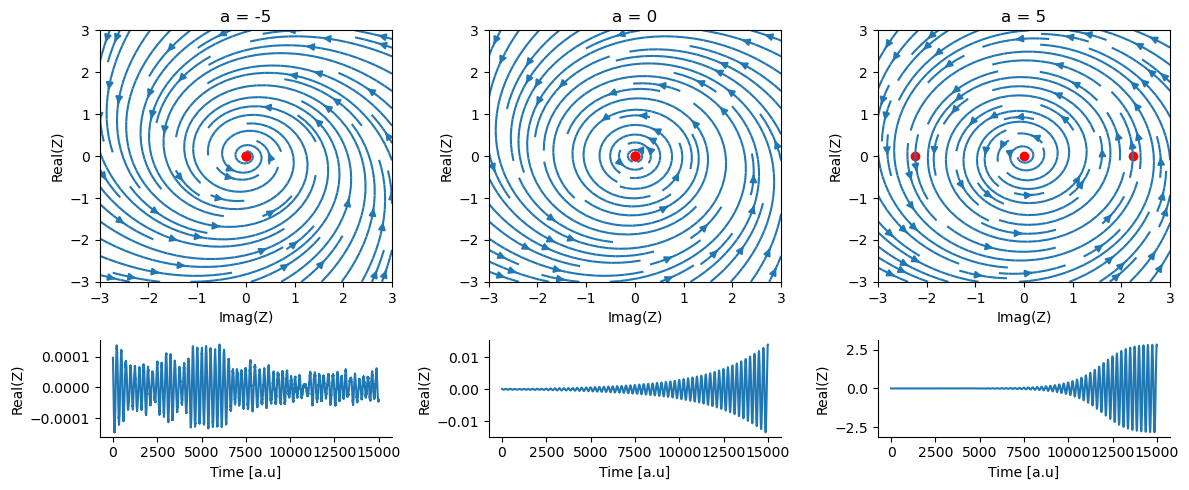

In [10]:
fig, axs = plt.subplot_mosaic([[0, 2, 4], [0, 2, 4], [1, 3, 5]], figsize=(12, 5))

pos = 0
for i, Z_ in enumerate(Z_noise):

    fp = np.sqrt(a_vec[i] + 1j * 0)
    if a_vec[i] < 0:
        fp = 0 + 1j * 0

    fixed_points = np.array([[0.0, 0.0], [fp.real, fp.imag], [-fp.real, -fp.imag]])

    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    dZdt = _ode(X + 1j * Y, a_vec[i], 40, 0)

    Xdot = dZdt.real
    Ydot = dZdt.imag

    plt.sca(axs[pos])
    axs[pos].streamplot(
        numpy.array(X), numpy.array(Y), numpy.array(Xdot), numpy.array(Ydot)
    )
    axs[pos].scatter(*fixed_points.T, color="r")
    plt.title(f"a = {a_vec[i]}")
    plt.xlabel("Imag(Z)")
    plt.ylabel("Real(Z)")

    pos = pos + 1
    plt.sca(axs[pos])
    axs[pos].plot(Z_.real)
    axs[pos].spines["top"].set_visible(False)
    axs[pos].spines["right"].set_visible(False)
    plt.xlabel("Time [a.u]")
    plt.ylabel("Real(Z)")
    pos = pos + 1

plt.tight_layout()

#### Stimulus encoding

In [11]:
simulate_jax = jax.vmap(simulate, in_axes=(None, None, None, None, 0, 0, None, None))

In [12]:
a_vec = np.linspace(-15, 5, 60)
beta_vec = np.geomspace(1e-4, 1e-3, 60)

In [13]:
T = np.arange(-0.5, 1, 1e-4)
I = np.zeros((100, T.shape[0]))
for i in range(100):
    I = I.at[i, (T >= 0) * (T <= 0.2)].set(1e-4 * i)

In [14]:
seeds = np.arange(100, dtype=int)

In [15]:
out1 = simulate_jax(40, -5, 1e-3, T, I, seeds, 1, "amp")
out2 = simulate_jax(40, 0, 1e-3, T, I, seeds, 1, "amp")
out3 = simulate_jax(40, 5, 1e-3, T, I, seeds, 1, "amp")

Text(0.5, 0, 'time [s]')

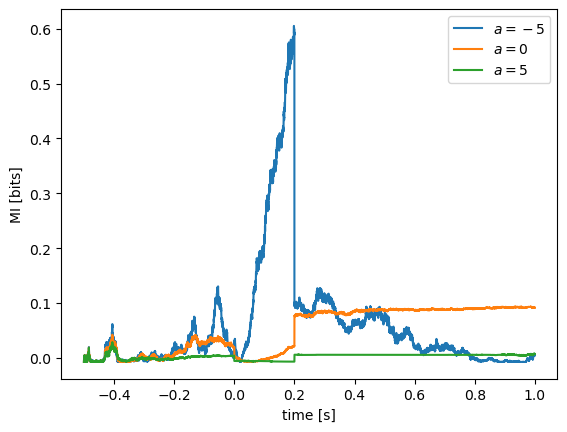

In [16]:
plt.plot(T, gcmi_nd_cc(numpy.asarray(out1 * np.conj(out1)), numpy.asarray(I), traxis=0))
plt.plot(T, gcmi_nd_cc(numpy.asarray(out2 * np.conj(out2)), numpy.asarray(I), traxis=0))
plt.plot(T, gcmi_nd_cc(numpy.asarray(out3 * np.conj(out3)), numpy.asarray(I), traxis=0))

plt.legend([r"$a = -5$", r"$a = 0$", r"$a = 5$"])

plt.ylabel("MI [bits]")
plt.xlabel("time [s]")

In [17]:
grid = np.array(np.meshgrid(a_vec, beta_vec)).T.reshape(-1, 2)
grid.shape

(3600, 2)

In [18]:
simulate_jax_2 = jax.vmap(
    simulate_jax, in_axes=(None, 0, 0, None, None, None, None, None)
)

In [19]:
blocks = np.array_split(np.arange(grid.shape[0]), 600)

In [20]:
grid.shape

(3600, 2)

In [21]:
out = []
for block in tqdm(blocks):
    out += [simulate_jax_2(40, grid[block, 0], grid[block, 1], T, I, seeds, 15, "amp")]

100%|██████████████████████████████████████████████████████| 600/600 [03:13<00:00,  3.09it/s]


In [22]:
out = numpy.concatenate(out, axis=0)

In [23]:
MIs = []
for _out in tqdm(out):
    try:
        MIs += [
            gcmi_nd_cc(
                numpy.asarray(_out * np.conj(_out)),
                numpy.asarray(I[..., ::15]),
                traxis=0,
            ).max()
        ]
    except:
        MIs += [0]

100%|████████████████████████████████████████████████████| 3600/3600 [01:53<00:00, 31.67it/s]


In [24]:
MIs_xr = xr.DataArray(
    numpy.stack(MIs).reshape(a_vec.shape[0], beta_vec.shape[0]),
    dims=("a", "beta"),
    coords=(a_vec, beta_vec),
    name="MI [bits]",
)

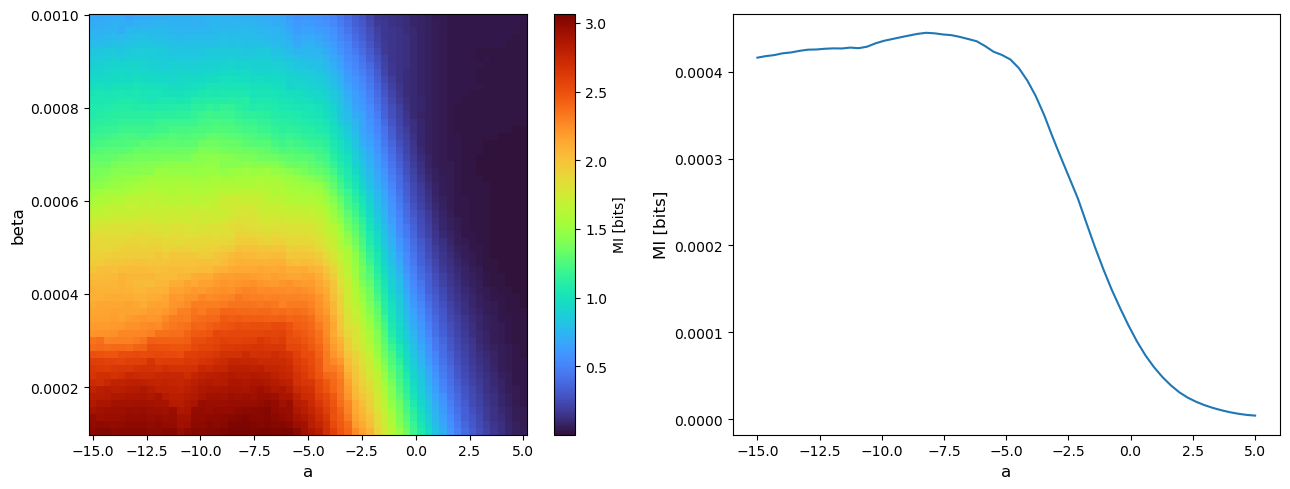

In [25]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
MIs_xr.T.plot.imshow(cmap="turbo")
plt.xlabel("a", fontsize=12)
plt.ylabel("beta", fontsize=12)

plt.subplot(122)
(MIs_xr * numpy.diff(beta_vec)[0]).sum("beta").plot()
plt.xlabel("a", fontsize=12)
plt.ylabel("MI [bits]", fontsize=12)

plt.tight_layout()

#### Two-nodes feed-forward connection (no-delays)

In [11]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/StuartLandauWBM/")

In [12]:
from src.models import simulate

In [13]:
Nareas = 2  # Number of areas
fsamp = 1 / 1e-4
time = np.arange(-0.5, 5, 1 / fsamp)
beta = 1e-3
Npoints = len(time)

f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

g = 5
C = np.array([[0, 0], [1, 0]])

In [14]:
T = np.linspace(-0.5, 1, Npoints)
I = np.zeros((100, 2, T.shape[0]))
for i in range(100):
    I = I.at[i, 0, (T >= 0) * (T <= 0.2)].set(1e-4 * i)

In [15]:
simulate_jax = jax.vmap(
    simulate, in_axes=(None, None, None, None, None, None, None, 0, 0, None, None)
)

In [16]:
seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z = (
    simulate_jax(C, g, f, np.array([-5, 0]), fsamp, beta, Npoints, I, seeds, "cpu", 15)
    .squeeze()
    .transpose(0, 2, 1)
)

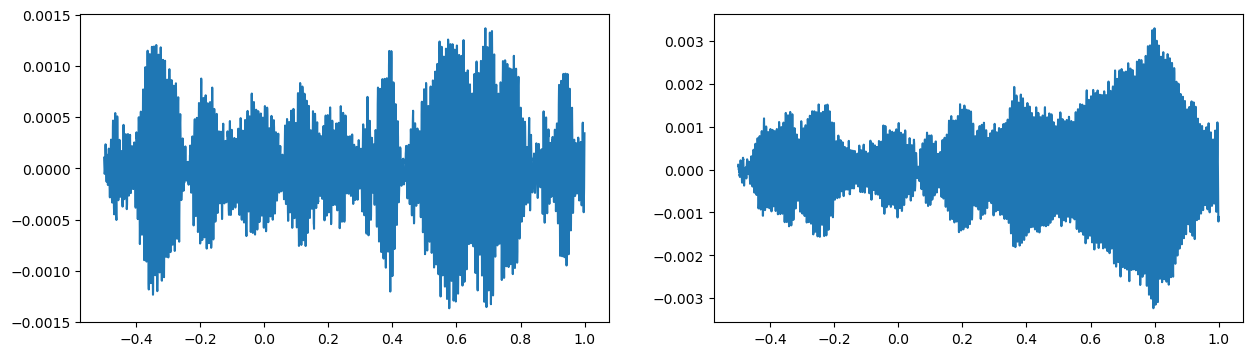

In [17]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(T[::15], Z[0, 0].real)
plt.subplot(122)
plt.plot(T[::15], Z[0, 1].real)

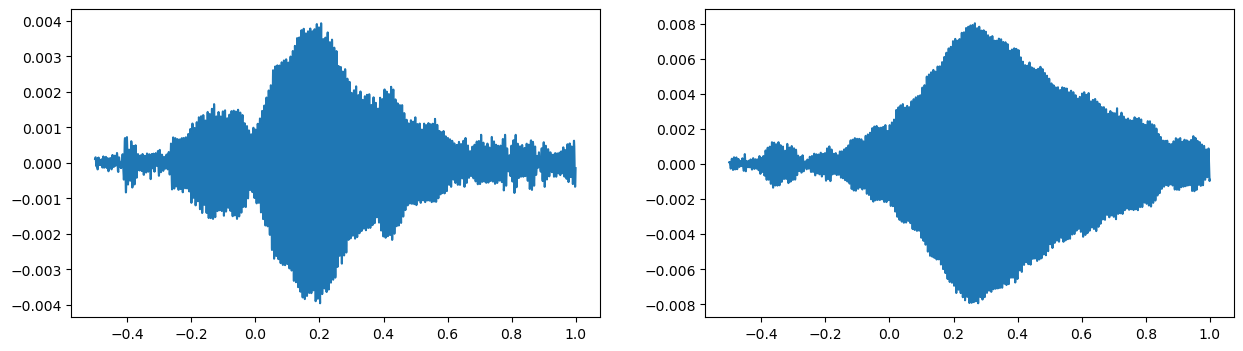

In [18]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(T[::15], Z[-1, 0].real)
plt.subplot(122)
plt.plot(T[::15], Z[-1, 1].real)

In [19]:
simulate_jax_2 = jax.vmap(
    simulate_jax,
    in_axes=(None, 0, None, None, None, None, None, None, None, None, None),
)

In [32]:
g_vec = np.linspace(0, 10, 60)

In [33]:
seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z_homogeneous = (
    numpy.asarray(
        simulate_jax_2(
            C, g_vec, f, np.array([-5, -5]), fsamp, beta, Npoints, I, seeds, "cpu", 15
        )
    )
    .squeeze()
    .transpose(0, 1, 3, 2)
)

seeds = numpy.random.randint(0, 20000, 100, dtype=int)


Z_heterogeneous = (
    numpy.asarray(
        simulate_jax_2(
            C, g_vec, f, np.array([-5, 0]), fsamp, beta, Npoints, I, seeds, "cpu", 15
        )
    )
    .squeeze()
    .transpose(0, 1, 3, 2)
)

In [53]:
def _mi(x, y, stim):

    # Define the function to compute MI using HOI and JAX
    mi_fcn = get_mi("gcmi")

    # vectorize the function to first and second dimension
    gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

    edge = x * np.conj(y)
    edge_r, edge_i = np.real(edge), np.imag(edge)

    E1 = np.stack((edge_r, edge_i), axis=1)
    E1 = np.moveaxis(E1, [0, 1], [-1, -2])

    # Stims across trials
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (x.shape[-1], 1, 1))

    E1 = copnorm_nd(E1, axis=-1)
    stim = copnorm_nd(stim, axis=-1)

    return gcmi(E1, stim).T

In [38]:
mi_homogeneous = []

for i in tqdm(range(60)):
    mi_homogeneous += [
        gcmi_nd_cc(
            Z_homogeneous[i, :, 0],
            Z_homogeneous[i, :, 1],
            I[:, 0, ::15],
            traxis=0,
        )
    ]

mi_homogeneous = np.stack(mi_homogeneous)

100%|████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  7.46it/s]


In [39]:
mi_heterogeneous = []

for i in tqdm(range(60)):
    mi_heterogeneous += [
        gcmi_nd_cc(
            Z_heterogeneous[i, :, 0],
            Z_heterogeneous[i, :, 1],
            I[:, 0, ::15],
            traxis=0,
        )
    ]

mi_heterogeneous = np.stack(mi_heterogeneous)

100%|████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.53it/s]


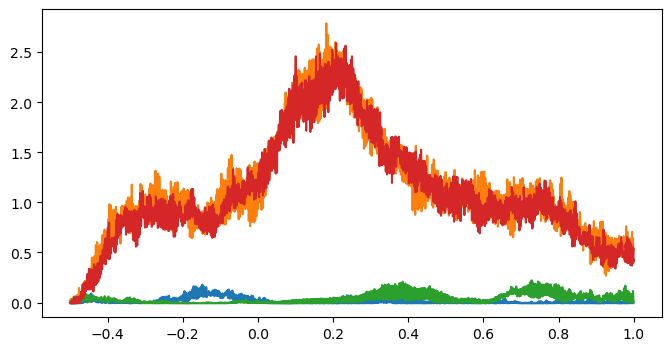

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(T[::15], mi_homogeneous[0])
plt.plot(T[::15], mi_homogeneous[-1])
plt.plot(T[::15], mi_heterogeneous[0])
plt.plot(T[::15], mi_heterogeneous[-1])

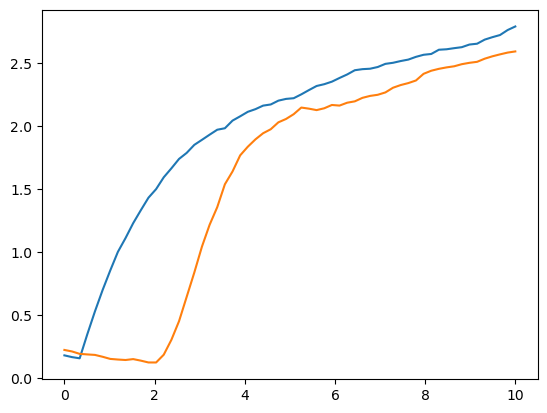

In [41]:
plt.plot(g_vec, mi_homogeneous.max(1))
plt.plot(g_vec, mi_heterogeneous.max(1))